# Praca domowa 6
### Jakub Lis

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import pandas as pd

In [2]:
faces = fetch_olivetti_faces()

Zaczniemy od podejrzenia opisu zbioru, na którym będzie wykonywana praca domowa - aby trochę lepiej się orientować, co mamy w nim dane.

In [3]:
print(faces['DESCR'])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Na początek możemy sprawdzić jak wyglądają przykładowe zdjęcia w zbiorze.

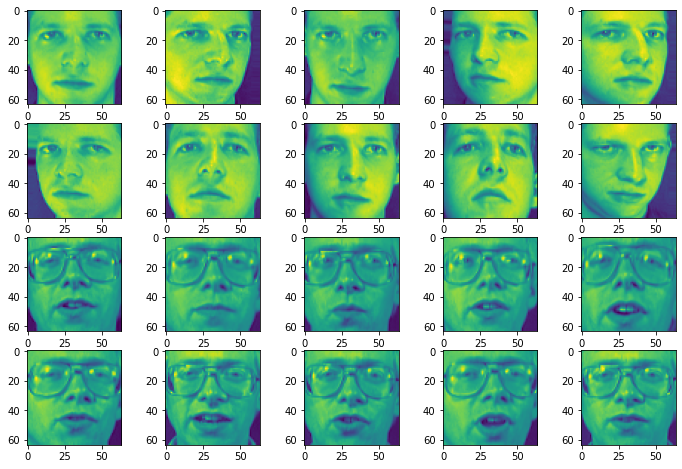

In [4]:
import matplotlib.pyplot as plt

images = faces.images

f, axarr = plt.subplots(4, 5, figsize=(12, 8))
for i in range(5):
    for j in range(4):
        axarr[j,i].imshow(np.array(images[i+5*j], dtype='float'))

Widzimy pierwsze 20 zdjęć w zbiorze. Z opisu wiemy też, że dla każdej osoby mamy po 10 zdjęć - a powyżej widzimy dwie ze wszystkich osób.

## Kompresja zbioru za pomocą PCA

Dalej będziemy się posługiwać (przynajmniej przy korzystaniu z PCA) z wartości w słowniku pod kluczem "data". Są to te same informacje co pod kluczem "images", z taką różnicą, że są one zapisane w jednej liści, a nie w macierzy.

In [5]:
data = faces.data
target = faces.target

Aby dobrać liczbę komponentów stworzymy wykres obrazujący ilość wyjaśnionej wariancji.

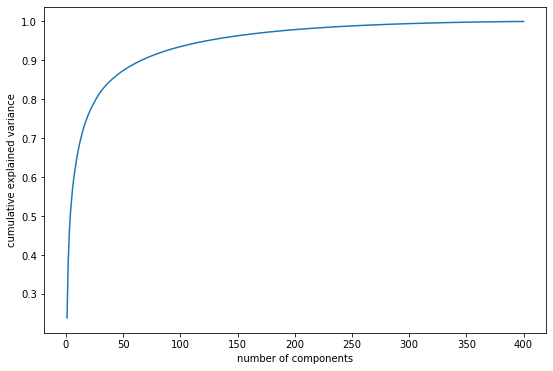

In [6]:
from sklearn.decomposition import PCA

pca = PCA().fit(data)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Postawmy sobie za odpowiednią liczbę komponentów taką, że 0.95 wariancji jest wyjaśnione. Możemy wyznaczyć najmniejsza liczbę komponentów, która to spełni:

In [7]:
min(np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0])

122

In [8]:
pca = PCA(n_components = 122)
data_transformed = pca.fit_transform(data)

Chcemy teraz wyznaczyć stopień kompresji:

In [9]:
cr = abs(data.shape[1]/data_transformed.shape[1])
print(cr)

33.57377049180328


Zatem szukany stopień kompresji wynosi w zaokrągleniu 33.57.

## Transformacja odwrotna

In [10]:
data_decompressed = pca.inverse_transform(data_transformed)

Przyjrzymy się teraz porównaniu obrazków początkowych (górny rząd) z obrazkami po transformacji i później transformacji odwrotnej (dolny rząd) - zobaczymy jak bardzo to je zniekształciło.

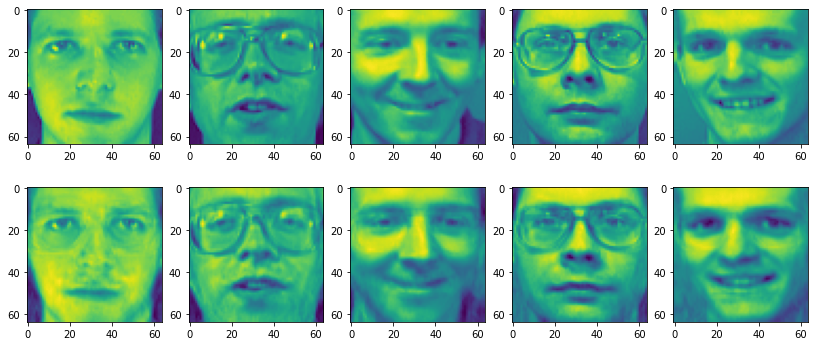

In [11]:
f, axarr = plt.subplots(2, 5, figsize=(14, 6))
for i in range(5):
    axarr[0,i].imshow(np.reshape(data[10*i], (64, 64)))
    axarr[1,i].imshow(np.reshape(data_decompressed[10*i], (64, 64)))

Widzimy, że obrazki są dosyć podobne i nie utraciliśmy wielu informacji podczas kompresji. Mimo wszystko mamy trochę zniekształceń (a przypomnijmy, że wyjaśnialność wariancji była na poziomie 95%).

Dalej chcemy policzyć błąd rekonstrukcji za pomocą RMSE.

In [12]:
from sklearn.metrics import mean_squared_error

rmse_scores = []

for i in range(len(data)):
    rmse_scores.append(
        np.sqrt(mean_squared_error(data[i], data_decompressed[i]))
    )

Błąd dla każdego obrazka zawarty jest aktualnie w liście rmse_scores. Najlepszym sposobem prezentacji otrzymanych wartości wydaje się boxplot, więc taki sobie wyplotujemy.

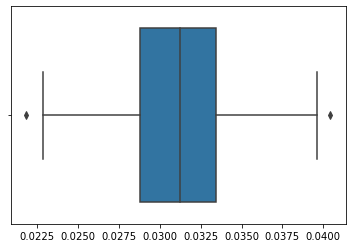

In [13]:
import seaborn as sns

sns.boxplot(x=rmse_scores)
plt.show()

Widzimy, że mamy pojedyncze wartości odstające z obu stron. Wygląda jakby wartości miały się rozkładać całkiem równomiernie po obu stronach od mediany, ale w tym celu możemy podejrzeć jeszcze jakby wyglądał histogram.

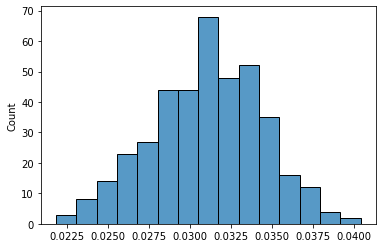

In [14]:
sns.histplot(rmse_scores)
plt.show()

Eozkład nie jest jakoś znacząco skośny, a dodatkowo po obu stronach mieliśmy po jednej wartości odstającej - możemy ostatecznie wyznaczyć średnią z naszych błędów (dlatego, że w tym przypadku będzie ona dobrą miarą) i na tym zakończyć ich badanie.

In [15]:
from statistics import mean

mean(rmse_scores)

0.03102739

## Modyfikacje obrazów

Zaczniemy od obrócenia naszych obrazów o 90 stopni.

In [16]:
from scipy.ndimage import rotate

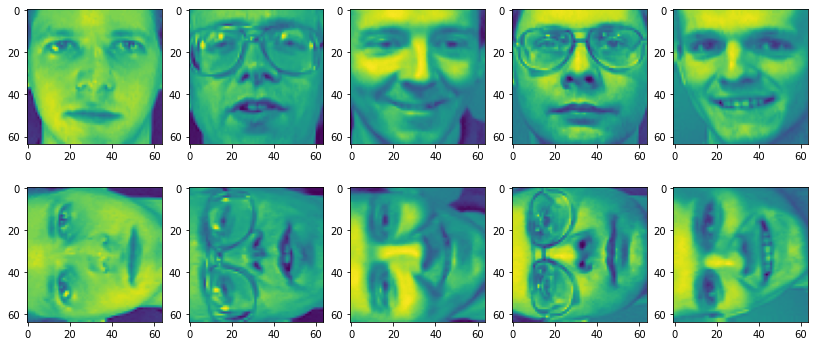

In [17]:
f, axarr = plt.subplots(2, 5, figsize=(14, 6))
for i in range(5):
    axarr[0,i].imshow(np.array(images[10*i], dtype='float'))
    axarr[1,i].imshow(np.array(rotate(images[10*i], 90), dtype='float'))

Na górze mamy oryginalne zdjęcia, a na dole obrócone o 90 stopni - w identyczny sposób można obrazać o dowolny kąt, najlepiej będący wieloktnością 90.

Teraz możemy spróbować przyciemnić obrazy:

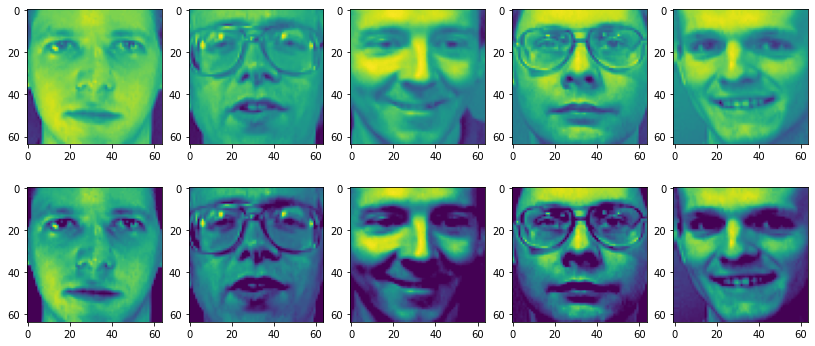

In [18]:
f, axarr = plt.subplots(2, 5, figsize=(14, 6))
for i in range(5):
    axarr[0,i].imshow(np.reshape(data[10*i], (64, 64)))
    axarr[1,i].imshow(np.reshape(np.clip(data[10*i]-0.4, 0, 1), (64, 64)))

W analogiczny sposób można zrobić rozjaśnienie:

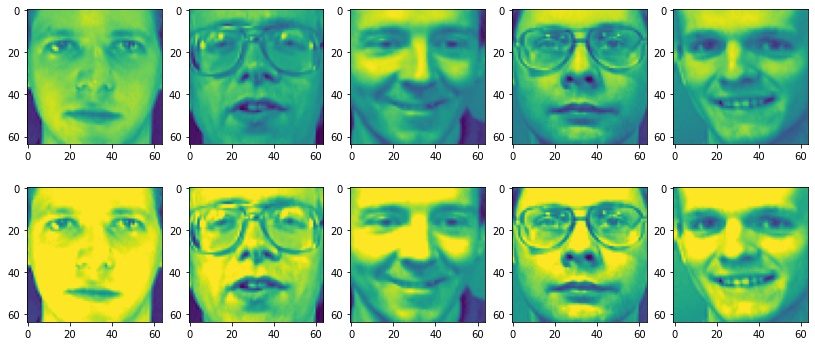

In [19]:
f, axarr = plt.subplots(2, 5, figsize=(14, 6))
for i in range(5):
    axarr[0,i].imshow(np.reshape(data[10*i], (64, 64)))
    axarr[1,i].imshow(np.reshape(np.clip(data[10*i]+0.3, 0, 1), (64, 64)))

## Transformacje zmodyfikowanych obrazów

Przygotujemy na początek wszystkie zdjęcia obrócone o 90 stopni.

In [20]:
data_rotated = []

for el in images:
    data_rotated.append(np.reshape(rotate(el, 90), 64*64))
    
data_rotated = np.array(data_rotated)

In [21]:
data_rotated_transformed = pca.fit_transform(data_rotated)
data_rotated_decompressed = pca.inverse_transform(data_rotated_transformed)

In [22]:
rmse_scores_rotated = []

for i in range(len(data)):
    rmse_scores_rotated.append(
        np.sqrt(mean_squared_error(data_rotated_decompressed[i], data_rotated[i]))
    )

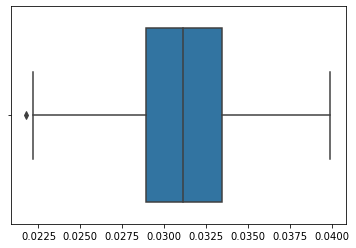

In [23]:
sns.boxplot(x=rmse_scores_rotated)
plt.show()

Teraz zobaczmy, czy otrzymamy inne wartości RMSE w przypadku zdjęć przyciemnianych.

In [24]:
data_darkened = []

for el in data:
    data_darkened.append(np.clip(el-0.4, 0, 1))
    
data_darkened = np.array(data_darkened)

data_darkened_transformed = pca.fit_transform(data_darkened)
data_darkened_decompressed = pca.inverse_transform(data_darkened_transformed)

rmse_scores_darkened = []

for i in range(len(data)):
    rmse_scores_darkened.append(
        np.sqrt(mean_squared_error(data_darkened_decompressed[i], data_darkened[i]))
    )

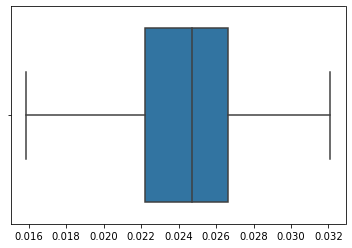

In [25]:
sns.boxplot(x=rmse_scores_darkened)
plt.show()

Na końcu przyjrzymy się zdjęciom rozjaśnionym.

In [26]:
data_lightened = []

for el in data:
    data_lightened.append(np.clip(el-0.4, 0, 1))
    
data_lightened = np.array(data_lightened)

data_lightened_transformed = pca.fit_transform(data_lightened)
data_lightened_decompressed = pca.inverse_transform(data_lightened_transformed)

rmse_scores_lightened = []

for i in range(len(data)):
    rmse_scores_lightened.append(
        np.sqrt(mean_squared_error(data_lightened_decompressed[i], data_lightened[i]))
    )

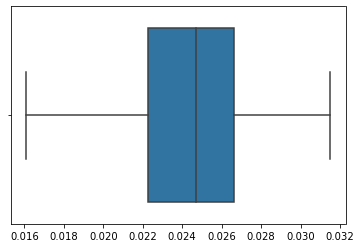

In [27]:
sns.boxplot(x=rmse_scores_lightened)
plt.show()

W celu dobrego porównania otrzymanych wartości zestawimy wszystkie boxploty na jednym wykresie.

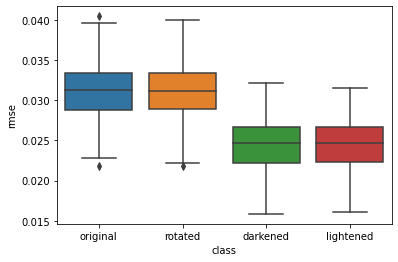

In [28]:
df = pd.DataFrame({"rmse": rmse_scores + rmse_scores_rotated + rmse_scores_darkened + rmse_scores_lightened, 
                   "class": ['original' for i in range(len(rmse_scores))] +
                            ['rotated' for i in range(len(rmse_scores_rotated))] + 
                            ['darkened' for i in range(len(rmse_scores_darkened))] +
                            ['lightened' for i in range(len(rmse_scores_lightened))]})
ax = sns.boxplot(x="class", y="rmse", data=df)
plt.show()

## Podsumowanie

Wygląda na to, że algorytm PCA może być wykorzystywany do wykrywania anomalii - otrzymaliśmy inne wartości RMSE dla obrazów, które były przyciemniane i rozjaśniane. Nie można jednak tego powiedzieć o obrocie o 90 stopni, gdzie boxplot wygląda bardzo podobnie.